In [1]:
# import packages
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, RidgeCV, Lasso, LassoCV
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import LabelEncoder, RobustScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sn
import statsmodels.api as sm
import numpy as np
import math 

In [2]:
# Read CSV train data file into DataFrame
train_df = pd.read_csv("train.csv")

# Read CSV test data file into DataFrame
test_df = pd.read_csv("test.csv")

# concat train and test for cleaning
combine_df = pd.concat((train_df, test_df))

# Part 1 - Cleaning the Dataset

In [3]:
# How many samples are there in the training set? 
len(train_df)
# There are 1,460 rows in the training set.

1460

In [4]:
#How many features?

# There are 80 features
len(train_df.keys())
# The keys are 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
#       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
#       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
#       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
#       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
#       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
#       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
#       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
#       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
#       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
#       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
#       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
#       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
#       'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF',
#       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC',
#       'Fence', 'MiscFeature', 'MiscVal', 'MoSold', 'YrSold', 'SaleType',
#       'SaleCondition', 'SalePrice'

81

In [5]:
# Which features are categorical?
cat_features=[i for i in combine_df.columns if train_df.dtypes[i]=='object']

cat_features

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleType',
 'SaleCondition']

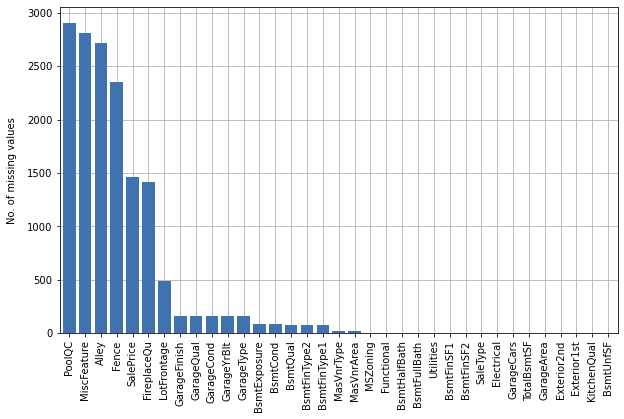

In [6]:
# What variables seem to be important? 
# Find features that contain NA values
nans = combine_df.isna().sum().sort_values(ascending=False)
nans = nans[nans > 0]
nans
fig, ax = plt.subplots(figsize=(10, 6))
ax.grid()
ax.bar(nans.index, nans.values, zorder=2, color="#3f72af")
ax.set_ylabel("No. of missing values", labelpad=10)
ax.set_xlim(-0.6, len(nans) - 0.4)
ax.xaxis.set_tick_params(rotation=90)
plt.show()

In [7]:
# Group 1:
group_1 = [
    'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageType',
    'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond',
    'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType'
]
combine_df[group_1] = combine_df[group_1].fillna("None")

# Group 2:
group_2 = [
    'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
    'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea'
]

combine_df[group_2] = combine_df[group_2].fillna(0)

# Group 3:
group_3a = [
    'Functional', 'MSZoning', 'Electrical', 'KitchenQual', 'Exterior1st',
    'Exterior2nd', 'SaleType', 'Utilities'
]

imputer = SimpleImputer(strategy='most_frequent')
combine_df[group_3a] = pd.DataFrame(imputer.fit_transform(combine_df[group_3a]), index=combine_df.index)

combine_df.LotFrontage = combine_df.LotFrontage.fillna(combine_df.LotFrontage.mean())
combine_df.GarageYrBlt = combine_df.GarageYrBlt.fillna(combine_df.YearBuilt)

In [8]:
# Ordinal categorical columns
label_encoding_cols = [
    "Alley", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2",
    "BsmtQual", "ExterCond", "ExterQual", "FireplaceQu", "Functional",
    "GarageCond", "GarageQual", "HeatingQC", "KitchenQual", "LandSlope",
    "LotShape", "PavedDrive", "PoolQC", "Street", "Utilities"
]

# Apply Label Encoder
label_encoder = LabelEncoder()

for col in label_encoding_cols:
    combine_df[col] = label_encoder.fit_transform(combine_df[col])

In [9]:
combine_df['totalSqFeet'] = combine_df['TotalBsmtSF'] + combine_df['1stFlrSF'] + combine_df['2ndFlrSF']
combine_df['totalBathroom'] = combine_df.FullBath + combine_df.BsmtFullBath + 0.5 * (combine_df.HalfBath + combine_df.BsmtHalfBath)
combine_df['houseAge'] = combine_df.YrSold - combine_df.YearBuilt
combine_df['reModeled'] = np.where(combine_df.YearRemodAdd == combine_df.YearBuilt, 0, 1)
combine_df['isNew'] = np.where(combine_df.YrSold == combine_df.YearBuilt, 1, 0)

In [10]:
cols = ["MSSubClass", "YrSold"]
combine_df[cols] = combine_df[cols].astype("object")

In [11]:
# Since each feature in this dataset is measured in completely different units and dimensions
# (e.g., LotArea vs LotFrontage), make sure that for regularized models (ridge and LASSO) you
# standardize your data first so that coefficients of smaller units are not unfairly penalized relative
# to coefficients of bigger units 
numerical_cols = combine_df.drop(columns=['Id', 'SalePrice']).select_dtypes(exclude=['object']).columns
scaler = RobustScaler()
combine_df[numerical_cols] = scaler.fit_transform(combine_df[numerical_cols])

# Part 2 - Exploring the features

Text(0, 0.5, 'Correlation')

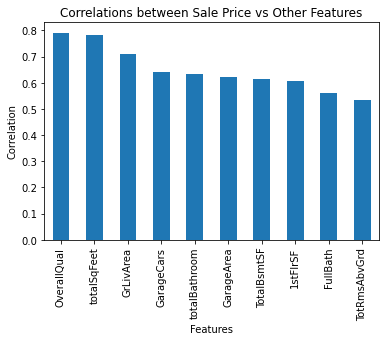

In [12]:
# Which seem to correlate with the sale price? 
top_correlations = combine_df.corr()
top_feature_columns = top_correlations['SalePrice'][(top_correlations['SalePrice'].values > 0.2) & (top_correlations['SalePrice'].values < 1.0)].sort_values(ascending=False)
top_feature_columns.iloc[:10].plot.bar(x='lab', y='val')
top_feature_columns
plt.title("Correlations between Sale Price vs Other Features")
plt.xlabel("Features")
plt.ylabel("Correlation")

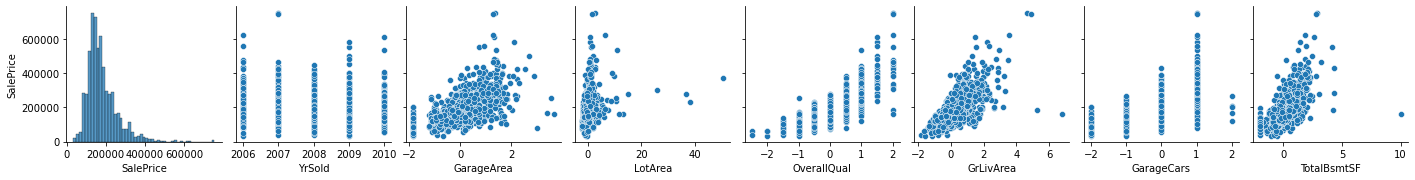

In [13]:
# Plot the relationship between sale price and year of sale, garage area, lot area, and other variables of
# your choice. Choose 7 variables and, along with the response variable, make a scatterplot
# matrix (hint: look at pandas.plotting.scatter_matrix or seaborn.pairplot). Explain what you see.
scatter_df = combine_df[['SalePrice', 'YrSold', 'GarageArea', 'LotArea', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF']]

# pairplot with hue day
sn.pairplot(scatter_df, y_vars='SalePrice')
# to show
plt.show()

In [14]:
# add dummies for categorical data
combine_df = pd.get_dummies(combine_df, drop_first=True)

In [15]:
# Declare X and Y to run varying models 
X = combine_df[:1460].drop(columns=['Id', 'SalePrice'])
Y = combine_df[:1460]['SalePrice']

# Part 3 - 95% Confidence Intervals (CI)

In [16]:
# Run ordinary least squares on all the features and report which
# features have a 95%confidence interval that contains 0 and which do not. Comment on what this means.

model = sm.OLS(Y, X).fit()
model_prediction = model.predict(X)
model_details = model.summary()
print(model_details)

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     66.93
Date:                Wed, 06 Oct 2021   Prob (F-statistic):               0.00
Time:                        17:40:47   Log-Likelihood:                -16682.
No. Observations:                1460   AIC:                         3.380e+04
Df Residuals:                    1240   BIC:                         3.497e+04
Df Model:                         219                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
LotFrontage            1467.44

In [17]:
# function that returns values to dataframe so we can query 
def results_summary_to_dataframe(results):
    '''take the result of an statsmodel results table and transforms it into a dataframe'''
    pvals = results.pvalues
    coeff = results.params
    conf_lower = results.conf_int()[0]
    conf_higher = results.conf_int()[1]

    results_df = pd.DataFrame({"pvals":pvals,
                               "coeff":coeff,
                               "conf_lower":conf_lower,
                               "conf_higher":conf_higher
                                })

    #Reordering...
    results_df = results_df[["coeff","pvals","conf_lower","conf_higher"]]
    return results_df

In [18]:
# Features that have a 95% confidence interval that contains 0 
results_df = results_summary_to_dataframe(model)
results_df[(0 <= results_df['conf_higher']) & (results_df['conf_lower'] <= 0)].head(20).sort_values(by='pvals',ascending=True)

,coeff,pvals,conf_lower,conf_higher
GarageCars,4590.701452,0.051280,-25.560819,9206.963722
Utilities,-56549.280807,0.059967,-115475.060623,2376.499008
GarageArea,3900.214864,0.062797,-208.539938,8008.969667
LotFrontage,1467.447262,0.072562,-134.547447,3069.441972
Fireplaces,2201.017856,0.118188,-560.802960,4962.838672
LotShape,2232.156350,0.185373,-1072.598159,5536.910859
HeatingQC,-2659.300611,0.204708,-6770.854055,1452.252834
FullBath,1870.094050,0.258395,-1374.674494,5114.862593
BsmtFinType1,1808.298460,0.293256,-1565.762012,5182.358931
ExterCond,832.878859,0.424182,-1211.032208,2876.789927


In [19]:
print("Number of variables that have 0 in the confidence interval: ", len(results_df[(0 <= results_df['conf_higher']) & (results_df['conf_lower'] <= 0)].sort_values(by='pvals',ascending=True)))

Number of variables that have 0 in the confidence interval:  172


In [20]:
print("Number of variables that do not have 0 in the confidence interval: ", len(results_df[((0 >= results_df['conf_higher']) | (results_df['conf_lower'] >= 0))].sort_values(by='pvals',ascending=True)))

Number of variables that do not have 0 in the confidence interval:  56


In [21]:
results_df# Features that have a 95% confidence interval that contains 0 and p value less than 0.05
results_df = results_summary_to_dataframe(model)
len(results_df[((0 >= results_df['conf_higher']) | (results_df['conf_lower'] >= 0)) & (results_df['pvals'] <= 0.05)].sort_values(by='pvals',ascending=True))

56

In [22]:
results_df[((0 >= results_df['conf_higher']) | (results_df['conf_lower'] >= 0)) & (results_df['pvals'] <= 0.05)].head(56).sort_values(by='pvals',ascending=True)

,coeff,pvals,conf_lower,conf_higher
RoofMatl_WdShngl,7.211741e+05,1.752409e-75,6.494112e+05,7.929371e+05
RoofMatl_CompShg,6.398820e+05,4.019737e-65,5.705021e+05,7.092620e+05
RoofMatl_Tar&Grv,6.348992e+05,3.647783e-52,5.567438e+05,7.130546e+05
RoofMatl_WdShake,6.127917e+05,1.064398e-50,5.361293e+05,6.894541e+05
RoofMatl_Membran,6.820382e+05,1.730827e-42,5.877728e+05,7.763037e+05
RoofMatl_Roll,6.260054e+05,2.578325e-42,5.392858e+05,7.127251e+05
RoofMatl_Metal,6.608286e+05,3.311917e-39,5.652824e+05,7.563749e+05
Condition2_PosN,-2.526581e+05,4.330174e-16,-3.128128e+05,-1.925034e+05
OverallQual,1.551180e+04,3.395345e-13,1.137565e+04,1.964795e+04
MSSubClass_150,8.325454e-09,7.766201e-13,6.069913e-09,1.058099e-08


In [23]:
# define all the significant features 
significant_features = results_df[((0 >= results_df['conf_higher']) | (results_df['conf_lower'] >= 0)) & (results_df['pvals'] <= 0.05)].head(20).sort_values(by='pvals',ascending=True).index.values
results_df[((0 >= results_df['conf_higher']) | (results_df['conf_lower'] >= 0)) & (results_df['pvals'] <= 0.05)].sort_values(by='pvals',ascending=True).index.values

array(['RoofMatl_WdShngl', 'RoofMatl_CompShg', 'RoofMatl_Tar&Grv',
       'RoofMatl_WdShake', 'RoofMatl_Membran', 'RoofMatl_Roll',
       'RoofMatl_Metal', 'Condition2_PosN', 'OverallQual',
       'MSSubClass_150', 'OverallCond', 'LotArea', 'KitchenQual',
       'MasVnrArea', 'Functional', 'YearBuilt', 'TotalBsmtSF',
       'GrLivArea', 'totalSqFeet', 'BsmtUnfSF', 'LowQualFinSF',
       'BsmtFinSF2', '1stFlrSF', '2ndFlrSF', 'BsmtFinSF1', 'ExterQual',
       'houseAge', 'Neighborhood_StoneBr', 'BedroomAbvGr', 'ScreenPorch',
       'BsmtExposure', 'isNew', 'LotConfig_CulDSac', 'Condition1_Norm',
       'BsmtQual', 'Neighborhood_NridgHt', 'LandContour_HLS',
       'TotRmsAbvGrd', 'SaleCondition_Normal', 'SaleType_New',
       'MSZoning_RM', 'YrSold_2009', 'Street', 'MSZoning_FV',
       'MSZoning_RL', 'WoodDeckSF', 'Fence_MnPrv', 'KitchenAbvGr',
       'YrSold_2010', 'Neighborhood_NoRidge', 'Neighborhood_NWAmes',
       'PoolQC', 'MSZoning_RH', 'MasVnrType_None', 'MoSold',
       'MasVnrT

# Ordinary Least Squares Model

In [24]:
# Split the training data into a training (80%) and test set (20%)
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.8, random_state = 786)

In [25]:
print("The number of features in OLS model is", len(X_train.columns))

The number of features in OLS model is 228


In [26]:
model2 = sm.OLS(y_train, X_train).fit()
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.932
Model:                            OLS   Adj. R-squared:                  0.917
Method:                 Least Squares   F-statistic:                     60.30
Date:                Wed, 06 Oct 2021   Prob (F-statistic):               0.00
Time:                        17:40:47   Log-Likelihood:                -13286.
No. Observations:                1168   AIC:                         2.701e+04
Df Residuals:                     950   BIC:                         2.811e+04
Df Model:                         217                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
LotFrontage             797.25

In [27]:
print('Mean Squared Error: {:.3f}'.format(mean_squared_error(y_test, model2.predict(X_test))))
print('Square Root of Mean Squared Error: {:.3f}'.format(math.sqrt(mean_squared_error(y_test, model2.predict(X_test)))))

Mean Squared Error: 3373710259.768
Square Root of Mean Squared Error: 58083.649


# k-Nearest Neighbors with 10-fold cross validation to choose k

In [28]:
# k-Nearest Neighbors with 10-fold cross validation to choose k
#create new a knn model
knn = KNeighborsRegressor()
# create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(1, 25)}
#use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn, param_grid, cv=10)
#fit model to data
knn_gscv.fit(X_train, y_train)

#check top performing n_neighbors value
best_k = knn_gscv.best_params_['n_neighbors']
print('Best k: {:.3f}'.format(best_k))

# report the testing accuracy
knn2 = KNeighborsRegressor(n_neighbors=best_k)
knn2.fit(X_train, y_train)
print('R-squared test score: {:.3f}'.format(knn2.score(X_test, y_test)))
print('Mean Squared Error: {:.3f}'.format(mean_squared_error(y_test, knn2.predict(X_test))))
print('Square Root of Mean Squared Error: {:.3f}'.format(math.sqrt(mean_squared_error(y_test, knn2.predict(X_test)))))

Best k: 23.000
R-squared test score: 0.694
Mean Squared Error: 1618178488.640
Square Root of Mean Squared Error: 40226.589


# Ridge regression with 10-fold cross validation to chose alpha

In [29]:
# Ridge regression with 10-fold cross validation to chose ¸
# The Ridge() function has an alpha argument ( λ , but with a different name!) that is used to tune the model
# Alpha values ranging from very big to very small, essentially covering the full 
# range of scenarios from the null model containing only the intercept, to the least squares fit
alphas = 10**np.linspace(10,-2,100)*0.5


ridgecv = RidgeCV(alphas = alphas, scoring = 'neg_mean_squared_error')
ridgecv.fit(X_train, y_train)
ridgecv.alpha_
print('Best alpha_: {:.3f}'.format(ridgecv.alpha_))

ridge = Ridge(alpha = ridgecv.alpha_)
ridge.fit(X_train, y_train)
print('R-squared test score: {:.3f}'.format(ridge.score(X_test, y_test)))
print('Mean Squared Error: {:.3f}'.format(mean_squared_error(y_test, ridge.predict(X_test))))
print('Square Root of Mean Squared Error: {:.3f}'.format(math.sqrt(mean_squared_error(y_test, ridge.predict(X_test)))))

Best alpha_: 21.644
R-squared test score: 0.816
Mean Squared Error: 970398890.946
Square Root of Mean Squared Error: 31151.226


# LASSO with 10-fold cross validation to chose alpha

In [30]:
# LASSO with 10-fold cross validation to chose
lassocv = LassoCV(alphas = None, cv = 10, max_iter = 100000)
lassocv.fit(X_train, y_train)

lasso = Lasso(max_iter = 10000)
lasso.set_params(alpha=lassocv.alpha_)
print('Best alpha_: {:.3f}'.format(lassocv.alpha_))
lasso.fit(X_train, y_train)
print('R-squared test score: {:.3f}'.format(lasso.score(X_test, y_test)))
print('Mean Squared Error: {:.3f}'.format(mean_squared_error(y_test, lasso.predict(X_test))))
print('Square Root of Mean Squared Error: {:.3f}'.format(math.sqrt(mean_squared_error(y_test, lasso.predict(X_test)))))

Best alpha_: 886.186
R-squared test score: 0.798
Mean Squared Error: 1066135660.059
Square Root of Mean Squared Error: 32651.733


# Backward stepwise regression with 10-fold cross validation to choose k

In [31]:
# Backward stepwise (linear) regression with 10-fold cross validation to choose k (number
# of features)

# Build Backward stepwise feature selection
sfs1 = SFS(LinearRegression(),k_features = 'best', forward=False, floating=False, scoring='r2',cv=10, n_jobs=-1)

# Perform SFFS
sfs1 = sfs1.fit(X_train, y_train)

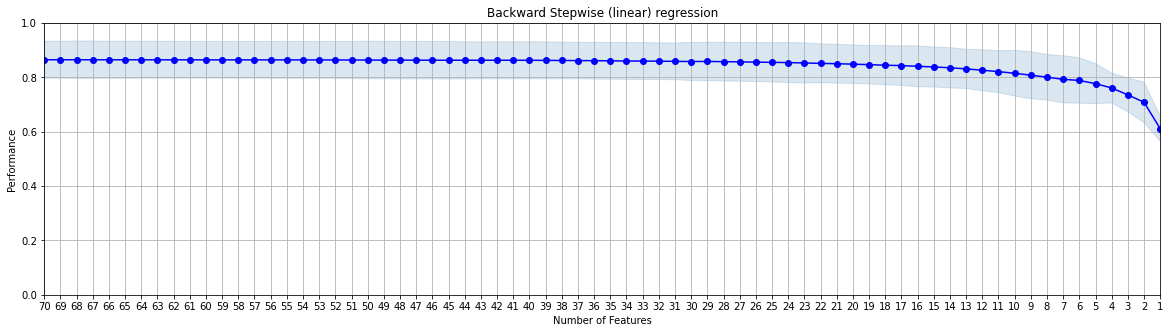

In [32]:
fig1 = plot_sfs(sfs1.get_metric_dict(), kind='std_dev', figsize=(20, 5))

plt.ylim([0, 1])
plt.xlim([70, 1])
plt.title('Backward Stepwise (linear) regression')
plt.grid()
plt.show()

In [33]:
# number of features
len(sfs1.k_feature_names_)

73

In [34]:
sfs1.k_feature_names_

('Street',
 'LandSlope',
 'OverallQual',
 'OverallCond',
 'ExterQual',
 'ExterCond',
 'BsmtQual',
 'BsmtExposure',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'KitchenQual',
 'Functional',
 'Fireplaces',
 'GarageCars',
 'ScreenPorch',
 'houseAge',
 'MSSubClass_50',
 'MSSubClass_70',
 'MSSubClass_120',
 'MSSubClass_160',
 'MSSubClass_180',
 'MSZoning_FV',
 'MSZoning_RH',
 'MSZoning_RL',
 'MSZoning_RM',
 'LandContour_HLS',
 'LandContour_Low',
 'LandContour_Lvl',
 'LotConfig_CulDSac',
 'LotConfig_FR3',
 'Neighborhood_BrDale',
 'Neighborhood_Crawfor',
 'Neighborhood_Gilbert',
 'Neighborhood_MeadowV',
 'Neighborhood_NPkVill',
 'Neighborhood_NWAmes',
 'Neighborhood_NoRidge',
 'Neighborhood_NridgHt',
 'Neighborhood_Sawyer',
 'Neighborhood_StoneBr',
 'Condition1_Norm',
 'Condition1_PosA',
 'Condition1_RRAn',
 'Condition1_RRNe',
 'Condition1_RRNn',
 'Condition2_RRAn',
 'BldgType_Duplex',
 'BldgType_TwnhsE',
 'HouseStyle_1Story',
 'RoofStyle_Mansard',
 'RoofStyle_Shed',
 'RoofMatl_WdShake',

In [35]:
# get best r-squared score 
sfs1.k_score_

0.8649371328627327

In [36]:
# Create Training data with Backward stepwise (linear) regression
X_train_backward = X_train[list(sfs1.k_feature_names_)]
backwards_stepwise_model = sm.OLS(y_train, X_train_backward).fit()
print(backwards_stepwise_model.summary())

                                 OLS Regression Results                                
Dep. Variable:              SalePrice   R-squared (uncentered):                   0.980
Model:                            OLS   Adj. R-squared (uncentered):              0.979
Method:                 Least Squares   F-statistic:                              745.1
Date:                Wed, 06 Oct 2021   Prob (F-statistic):                        0.00
Time:                        18:05:35   Log-Likelihood:                         -13619.
No. Observations:                1168   AIC:                                  2.738e+04
Df Residuals:                    1096   BIC:                                  2.775e+04
Df Model:                          72                                                  
Covariance Type:            nonrobust                                                  
                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

In [37]:
X_test_backward = X_test[list(sfs1.k_feature_names_)]
print('Mean Squared Error: {:.3f}'.format(mean_squared_error(y_test, backwards_stepwise_model.predict(X_test_backward))))
print('Square Root of Mean Squared Error: {:.3f}'.format(math.sqrt(mean_squared_error(y_test, backwards_stepwise_model.predict(X_test_backward)))))

Mean Squared Error: 953634758.079
Square Root of Mean Squared Error: 30880.977


# Forward stepwise regression with 10-fold cross validation to choose k


In [38]:
# Forward stepwise (linear) regression with 10-fold cross validation to choose k (number
# of features)

# Build step forward feature selection
sfs2 = SFS(LinearRegression(), k_features = 'best', forward=True, floating=False, scoring='r2',cv=10, n_jobs=-1)

# Perform SFFS
sfs2 = sfs2.fit(X_train, y_train)

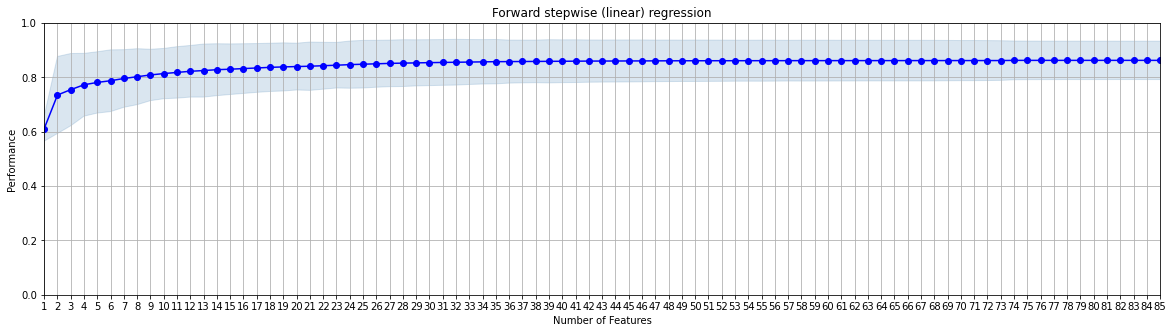

In [39]:
fig2 = plot_sfs(sfs2.get_metric_dict(), kind='std_dev', figsize=(20, 5))

plt.ylim([0, 1])
plt.xlim([1, 85])
plt.title('Forward stepwise (linear) regression')
plt.grid()
plt.show()

In [40]:
# number of features
len(sfs2.k_feature_names_)

81

In [41]:
sfs2.k_feature_names_

('Utilities',
 'LandSlope',
 'OverallQual',
 'OverallCond',
 'ExterQual',
 'ExterCond',
 'BsmtQual',
 'BsmtExposure',
 'BsmtFinType1',
 'GrLivArea',
 'KitchenAbvGr',
 'KitchenQual',
 'Functional',
 'Fireplaces',
 'GarageCars',
 'ScreenPorch',
 'totalSqFeet',
 'totalBathroom',
 'houseAge',
 'MSSubClass_45',
 'MSSubClass_50',
 'MSSubClass_60',
 'MSSubClass_120',
 'MSSubClass_150',
 'MSSubClass_160',
 'MSSubClass_180',
 'MSZoning_RM',
 'LandContour_HLS',
 'LandContour_Lvl',
 'LotConfig_CulDSac',
 'LotConfig_FR2',
 'LotConfig_Inside',
 'Neighborhood_Blueste',
 'Neighborhood_BrDale',
 'Neighborhood_ClearCr',
 'Neighborhood_CollgCr',
 'Neighborhood_Crawfor',
 'Neighborhood_Gilbert',
 'Neighborhood_IDOTRR',
 'Neighborhood_MeadowV',
 'Neighborhood_NAmes',
 'Neighborhood_NPkVill',
 'Neighborhood_NoRidge',
 'Neighborhood_NridgHt',
 'Neighborhood_Sawyer',
 'Neighborhood_SawyerW',
 'Neighborhood_Somerst',
 'Neighborhood_StoneBr',
 'Neighborhood_Veenker',
 'Condition1_Norm',
 'Condition1_PosA',
 'C

In [42]:
# get best r-squared score for Forward stepwise (linear) regression
sfs2.k_score_

0.8625756636723947

In [43]:
# Create Training data with Forward stepwise (linear) regression
X_train_forward = X_train[list(sfs2.k_feature_names_)]
forward_stepwise_model = sm.OLS(y_train, X_train_forward).fit()
print(forward_stepwise_model.summary())

                                 OLS Regression Results                                
Dep. Variable:              SalePrice   R-squared (uncentered):                   0.979
Model:                            OLS   Adj. R-squared (uncentered):              0.977
Method:                 Least Squares   F-statistic:                              646.0
Date:                Wed, 06 Oct 2021   Prob (F-statistic):                        0.00
Time:                        18:16:52   Log-Likelihood:                         -13652.
No. Observations:                1168   AIC:                                  2.746e+04
Df Residuals:                    1090   BIC:                                  2.785e+04
Df Model:                          78                                                  
Covariance Type:            nonrobust                                                  
                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

In [44]:
X_test_forward = X_test[list(sfs2.k_feature_names_)]
print('Mean Squared Error: {:.3f}'.format(mean_squared_error(y_test, forward_stepwise_model.predict(X_test_forward))))
print('Square Root of Mean Squared Error: {:.3f}'.format(math.sqrt(mean_squared_error(y_test, forward_stepwise_model.predict(X_test_forward)))))

Mean Squared Error: 918282194.592
Square Root of Mean Squared Error: 30303.171


# Add Quadratic Features 

In [45]:
# polynomial features for train dataset signifiant features 
p_X_Train = PolynomialFeatures(degree=2, include_bias=False).fit(X_train)
poly_X_train = pd.DataFrame(p_X_Train.transform(X_train), columns=p_X_Train.get_feature_names(X_train.columns.values))

In [46]:
len(poly_X_train.columns)

26334

In [47]:
# polynomial features for test dataset signifiant features 
p_X_test = PolynomialFeatures(degree=2, include_bias=False).fit(X_test)
poly_X_test = pd.DataFrame(p_X_test.transform(X_test), columns=p_X_test.get_feature_names(X_test.columns.values))

# Quadratic Features - k-Nearest Neighbors with 10-fold cross validation

In [48]:
# k-Nearest Neighbors with 10-fold cross validation to choose k
#create new a knn model
knn_quadratic = KNeighborsRegressor()
# create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(1, 25)}
#use gridsearch to test all values for n_neighbors
knn_quadratic_gscv = GridSearchCV(knn_quadratic, param_grid, cv=10)
#fit model to data
knn_quadratic_gscv.fit(poly_X_train, y_train)

#check top performing n_neighbors value
best_k = knn_gscv.best_params_['n_neighbors']
print('Best k: {:.3f}'.format(best_k))

# report the testing accuracy
knn3 = KNeighborsRegressor(n_neighbors=best_k)
knn3.fit(poly_X_train, y_train)
print('R-squared test score: {:.3f}'.format(knn3.score(poly_X_test, y_test)))
print('Square Root of Mean Squared Error: {:.3f}'.format(math.sqrt(mean_squared_error(y_test, knn3.predict(poly_X_test)))))

Best k: 23.000
R-squared test score: 0.655
Square Root of Mean Squared Error: 42674.115


# Quadratic Features - Ridge regression with 10-fold cross validation 

In [49]:
# Ridge regression with 10-fold cross validation to chose ¸
# The Ridge() function has an alpha argument ( λ , but with a different name!) that is used to tune the model
# Alpha values ranging from very big to very small, essentially covering the full 
# range of scenarios from the null model containing only the intercept, to the least squares fit
alphas = 10**np.linspace(10,-2,100)*0.5

ridgecv = RidgeCV(alphas = alphas, scoring = 'neg_mean_squared_error')
ridgecv.fit(poly_X_train, y_train)
ridgecv.alpha_
print('Best alpha_: {:.3f}'.format(ridgecv.alpha_))

ridge2 = Ridge(alpha = ridgecv.alpha_)
ridge2.fit(poly_X_train, y_train)
print('R-squared test score: {:.3f}'.format(ridge2.score(poly_X_test, y_test)))
print('Square Root of Mean Squared Error: {:.3f}'.format(math.sqrt(mean_squared_error(y_test, ridge2.predict(poly_X_test)))))

Best alpha_: 75995554.148
R-squared test score: 0.099
Square Root of Mean Squared Error: 68981.473


# Quadratic Features - LASSO with 10-fold cross validation

In [50]:
# LASSO with 10-fold cross validation
lassocv = LassoCV(alphas = None, cv = 10, max_iter = 100000)
lassocv.fit(poly_X_train, y_train)

lasso2 = Lasso(max_iter = 10000)
lasso2.set_params(alpha=lassocv.alpha_)
print('Best alpha_: {:.3f}'.format(lassocv.alpha_))
lasso2.fit(poly_X_train, y_train)
print('R-squared test score: {:.3f}'.format(lasso2.score(poly_X_test, y_test)))
print('Square Root of Mean Squared Error: {:.3f}'.format(math.sqrt(mean_squared_error(y_test, lasso2.predict(poly_X_test)))))

Best alpha_: 33916379.071
R-squared test score: 0.016
Square Root of Mean Squared Error: 72080.139


# Kaggle Competition - Ridge Regression

In [51]:
# Ridge regression with 10-fold cross validation to chose ¸
# The Ridge() function has an alpha argument ( λ , but with a different name!) that is used to tune the model
# Alpha values ranging from very big to very small, essentially covering the full 
# range of scenarios from the null model containing only the intercept, to the least squares fit
alphas = 10**np.linspace(10,-2,100)*0.5


ridgecv = RidgeCV(alphas = alphas, scoring = 'neg_mean_squared_error')
ridgecv.fit(X, Y)
ridgecv.alpha_
print('Best alpha_: {:.3f}'.format(ridgecv.alpha_))

ridge_kaggle = Ridge(alpha = ridgecv.alpha_)
ridge_kaggle.fit(X, Y)

Best alpha_: 12.385


Ridge(alpha=12.38538177995857)

In [52]:
test_data = combine_df[1460:].drop(columns=['Id', 'SalePrice'])

In [53]:
ridge_kaggle.predict(test_data)

array([104498.8055456 , 156497.013231  , 171598.77291816, ...,
       156245.89954293, 103300.18943854, 233924.8364987 ])

In [54]:
test_results = pd.DataFrame(ridge_kaggle.predict(test_data))
test_results.to_csv('kaggle_housing_ridge.csv')

# Kaggle Competition - Forward Feature Selection

In [55]:
# Build step forward feature selection
sfs2 = SFS(LinearRegression(), k_features = 'best', forward=True, floating=False, scoring='r2',cv=10, n_jobs=-1)

# Perform SFFS
sfs2 = sfs2.fit(X, Y)

In [56]:
# Create Training data with Forward stepwise (linear) regression
X_forward = X[list(sfs2.k_feature_names_)]
X_forward_stepwise_model = sm.OLS(Y, X_forward).fit()

In [57]:
test_data = combine_df[1460:]
test_data = test_data[list(sfs2.k_feature_names_)]

In [58]:
test_results = pd.DataFrame(X_forward_stepwise_model.predict(test_data))
test_results.to_csv('kaggle_housing_forward.csv')

In [59]:
X_forward_stepwise_model.predict(test_data)

0       106300.232750
1       166875.872214
2       168906.066958
3       185013.994964
4       223612.931965
            ...      
1454     65604.135304
1455     59215.116687
1456    169297.104259
1457    112679.837880
1458    228913.208480
Length: 1459, dtype: float64

# Kaggle Competition - Backwards Stepwise Regression


In [60]:
# Build Backward stepwise feature selection
sfs1 = SFS(LinearRegression(),k_features = 'best', forward=False, floating=False, scoring='r2',cv=10, n_jobs=-1)

# Perform SFFS
sfs1 = sfs1.fit(X, Y)

In [61]:
# Create Training data with Forward stepwise (linear) regression
X_backwards = X[list(sfs1.k_feature_names_)]
X_backwards_stepwise_model = sm.OLS(Y, X_backwards).fit()

In [62]:
test_data = combine_df[1460:]
test_data = test_data[list(sfs1.k_feature_names_)]

In [63]:
test_results = pd.DataFrame(X_backwards_stepwise_model.predict(test_data))
test_results.to_csv('kaggle_housing_backwards.csv')